In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

num_examples = 240000
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 20
shape = num_examples, 28, 28, 1
steps = 0
label_smoothing = 0.9

'''
A simple function to grab a single example from the training tf records files
'''
def read_and_decode_single_example(filename):
    IMAGE_SIZE = 28
    CLASSES = 10
    
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
            'label': tf.FixedLenFeature([CLASSES], tf.float32),
            'image': tf.FixedLenFeature([IMAGE_SIZE*IMAGE_SIZE], tf.float32)
        })
    label = features['label']
    image = features['image']
    
    # The following block is intended to normalize the image data to values between 
    # -1 and 1 because 
    # Subtract MAX/2 from each element of image, it is now between -128 and 127
    # Divide each element of image by the new max, now the image should be between -1 and 1
    # Reshape it back into the square image
    
    #image = tf.subtract(image, tf.divide(tf.reduce_max(image), 2))
    image = tf.divide(image, tf.reduce_max(image))
    #image = tf.subtract(image, 0.5)
    image = tf.reshape(image, (IMAGE_SIZE, IMAGE_SIZE, 1))
    return label, image

label, image = read_and_decode_single_example("./data/trainE.tfrecords")

images_batch, labels_batch = tf.train.shuffle_batch(
    [image, label], batch_size=batch_size,
    capacity=2000,
    min_after_dequeue=400)




In [2]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

In [3]:
'''
This 'network' is one big mathematical nonlinear function to transform a given image
into a binary calssification of wether or not this image came from the training dataset
'''
def discriminator(inp_img, reuse = False):
    alpha = 0.2
    NUM_FILTERS = 64
    with tf.variable_scope('discriminator', reuse=reuse):
        #We need to take the input image and decompose it into its filters
        stage_01 = tf.layers.conv2d(inp_img, NUM_FILTERS, 5, 2, padding = 'SAME')
        norm1 = tf.layers.batch_normalization(stage_01)
        lrel1 = tf.maximum(alpha*norm1, norm1)

        #Then again...
        stage_02 = tf.layers.conv2d(lrel1, NUM_FILTERS*2, 5, 2, padding = 'SAME')
        norm2 = tf.layers.batch_normalization(stage_02)
        lrel2 = tf.maximum(alpha*norm2,norm2)
        
        #Then again...
        stage_03 = tf.layers.conv2d(lrel2, NUM_FILTERS*4, 5, 1, padding = 'SAME')
        norm3 = tf.layers.batch_normalization(stage_03)
        lrel3 = tf.maximum(alpha*norm3,norm3)

        #Now we finally flatten it and get the classification
        flat = tf.reshape(lrel3, (-1,(NUM_FILTERS*4)*4*4), name="Flatten")

        #Dense fully connected 
        class2 = tf.layers.dense(flat, 1)

        out = tf.sigmoid(class2)
    
    return out, class2
    

In [4]:
'''
This is one big mathematical transformation function from an input vector of noise to 
an image of a handwritten digit
'''
def generator(noise_inp, output_dim, training = True):
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not training):
        #We first we push the the noise through a fully connected layer
        stage_0 = tf.layers.dense(noise_inp, 2*2*256)

        #Begin the convolutional stages of the network via a reshape
        stage_01 = tf.reshape(stage_0, (-1, 2, 2, 256), 'BeginConvStage') #We have to reshape the fully connected layer to allow conv
        norm1 = tf.layers.batch_normalization(stage_01, training = training) 
        lrel1 = tf.maximum(alpha * norm1, norm1) #This functions like a leaky relu, allowing 0.2n for n<0

        #CONV 1
        '''
        Here we begin capturing small shapes from our fully connected noise outputs
        '''
        stage_02 = tf.layers.conv2d_transpose(lrel1, 128, 5, 2, padding = 'VALID')    
        norm2 = tf.layers.batch_normalization(stage_02, training = training)
        lrel2 = tf.maximum(alpha * norm2, norm2)

        #CONV2
        '''
        Here we add a few mor filters to capture larger sections and shapes
        perhaps combining those from the earlier steps like lego
        '''
        stage_03 = tf.layers.conv2d_transpose(lrel2, 128, 5, 2, padding = 'SAME')
        norm3 = tf.layers.batch_normalization(stage_03, training = training)
        lrel3 = tf.maximum(alpha * norm3, norm3)

        #CONV4-ish
        '''
        Here we are creating a transpose convolution so that we can use the tanh output activation
        '''
        stage_04 = tf.layers.conv2d_transpose(lrel3, output_dim, 5, 2, padding = 'SAME')

        #Using tanh as the output function 
        output = tf.tanh(stage_04)
    
    return output

In [5]:
def net_loss(real_image, noise_input, output_dim):
    label_smoothing = 0.9
    gen_net = generator(noise_input, output_dim)
    cop_real, logit_real = discriminator(real_image)
    cop_fake, logit_fake = discriminator(gen_net, reuse=True)
    
    real_cop_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
        logits = logit_real,
        labels = tf.zeros_like(cop_real) + (1-label_smoothing) ))
    
    fake_cop_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
        logits = logit_fake,
        labels = tf.ones_like(cop_fake) * label_smoothing ))
    
    cop_loss = fake_cop_loss + real_cop_loss
                                                  
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
        logits = logit_fake,
        labels = tf.zeros_like(cop_fake) + (1-label_smoothing) ))
    
    return cop_loss, gen_loss
    

In [6]:
#**THIS WAS TAKEN FROM SOMEWHERE**#
# I didnt do the optimizations myself because they seem standard and I didnt want to mess up the grabbing of all
# the small trainable variables. 

In [7]:
def net_opt(cop_loss, gen_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(cop_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(gen_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [8]:
#A small chunk of code dedicated to generating updates for the human overseeing the progress

In [9]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, example):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    
    # This outputs example images to show training progress
    # The transpose is because it seems like the network or the record
    # has stored the images sideways and I find it nicer to see it correctly displayed
    imarr = np.array(samples)
    imarr = np.resize(np.transpose(imarr),(28,28))
    exarr = np.array(example)
    exarr = np.resize(np.transpose(exarr), (28,28))
    
    print("Network generated image...")
    plt.imshow(imarr)
    plt.show()
    print("Example image from dataset...")
    plt.imshow(exarr)
    plt.show()
    

In [10]:
#Bring everything togeather now

Epoch 1/20... Discriminator Loss: 0.6619... Generator Loss: 2.0430
Network generated image...


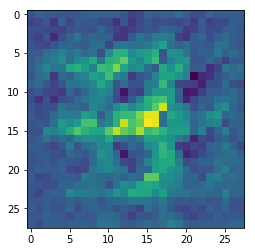

Example image from dataset...


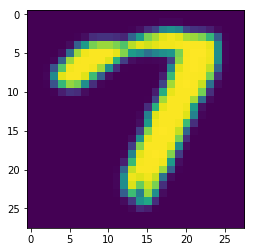

Epoch 1/20... Discriminator Loss: 0.6634... Generator Loss: 1.7904
Network generated image...


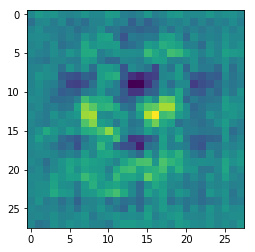

Example image from dataset...


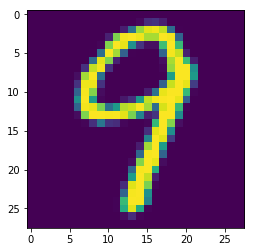

Epoch 1/20... Discriminator Loss: 0.6648... Generator Loss: 1.7382
Network generated image...


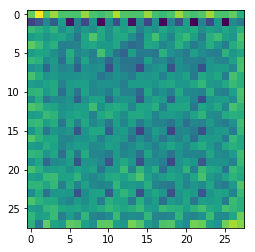

Example image from dataset...


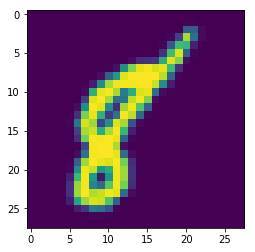

Epoch 1/20... Discriminator Loss: 0.6650... Generator Loss: 1.7118
Network generated image...


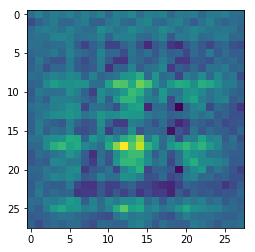

Example image from dataset...


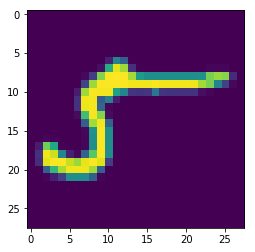

Epoch 2/20... Discriminator Loss: 0.6596... Generator Loss: 1.8714
Network generated image...


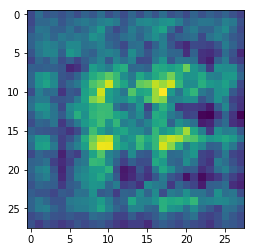

Example image from dataset...


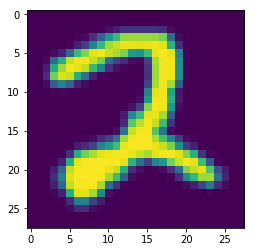

Epoch 2/20... Discriminator Loss: 0.6647... Generator Loss: 1.7020
Network generated image...


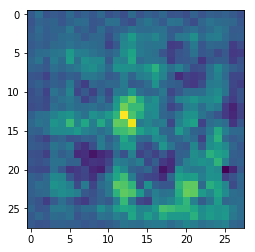

Example image from dataset...


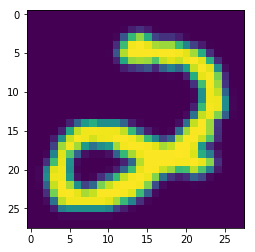

Epoch 2/20... Discriminator Loss: 0.6578... Generator Loss: 1.8552
Network generated image...


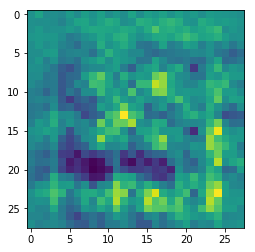

Example image from dataset...


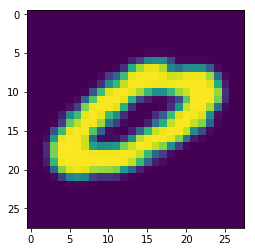

Epoch 2/20... Discriminator Loss: 0.6696... Generator Loss: 1.6646
Network generated image...


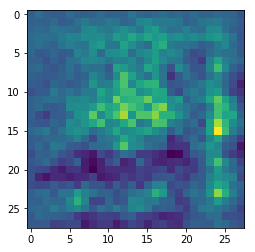

Example image from dataset...


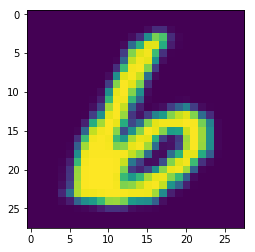

Epoch 3/20... Discriminator Loss: 0.6527... Generator Loss: 1.9704
Network generated image...


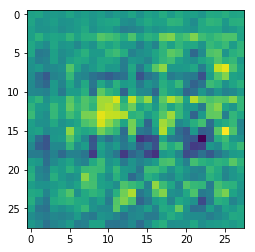

Example image from dataset...


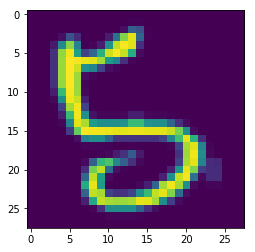

Epoch 3/20... Discriminator Loss: 0.6536... Generator Loss: 1.9381
Network generated image...


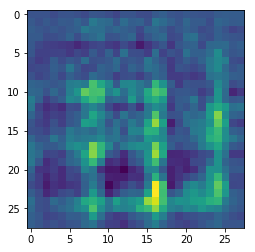

Example image from dataset...


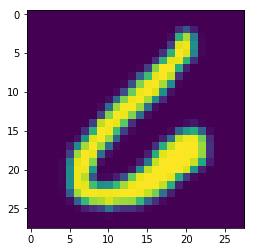

Epoch 3/20... Discriminator Loss: 0.6549... Generator Loss: 2.0082
Network generated image...


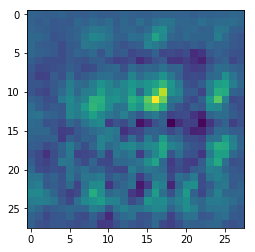

Example image from dataset...


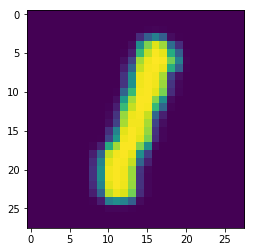

Epoch 3/20... Discriminator Loss: 0.6574... Generator Loss: 1.8593
Network generated image...


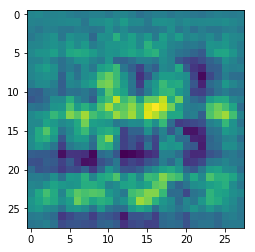

Example image from dataset...


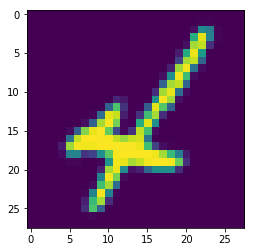

Epoch 4/20... Discriminator Loss: 0.6511... Generator Loss: 2.0296
Network generated image...


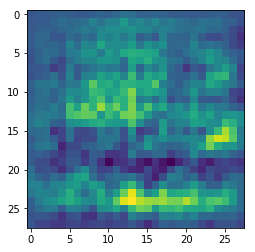

Example image from dataset...


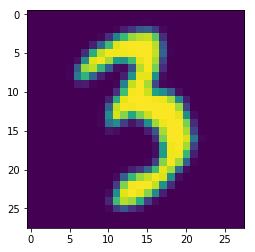

Epoch 4/20... Discriminator Loss: 0.6693... Generator Loss: 1.7085
Network generated image...


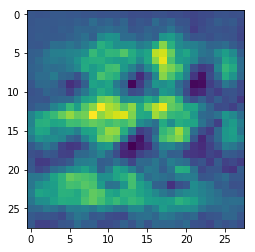

Example image from dataset...


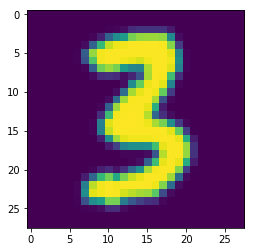

Epoch 4/20... Discriminator Loss: 0.6525... Generator Loss: 1.9621
Network generated image...


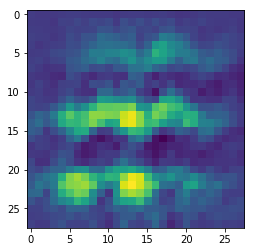

Example image from dataset...


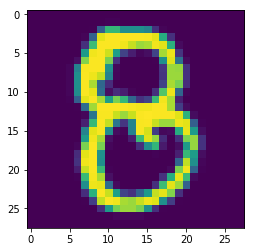

Epoch 4/20... Discriminator Loss: 0.6589... Generator Loss: 2.0070
Network generated image...


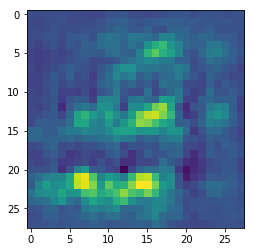

Example image from dataset...


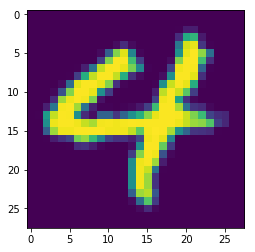

Epoch 5/20... Discriminator Loss: 0.6519... Generator Loss: 1.9852
Network generated image...


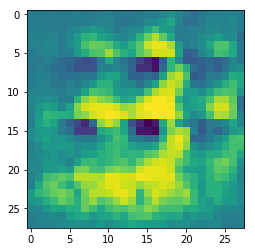

Example image from dataset...


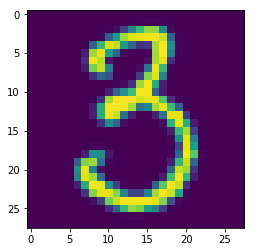

Epoch 5/20... Discriminator Loss: 0.6546... Generator Loss: 1.9714
Network generated image...


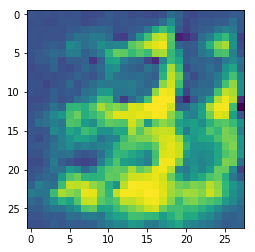

Example image from dataset...


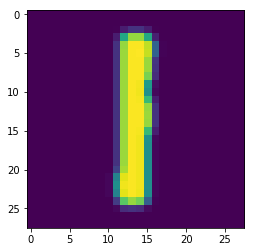

Epoch 5/20... Discriminator Loss: 0.6525... Generator Loss: 1.9876
Network generated image...


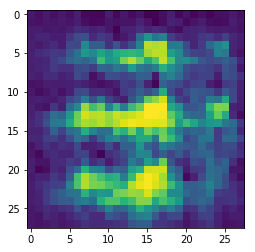

Example image from dataset...


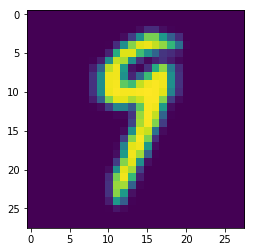

Epoch 5/20... Discriminator Loss: 0.6546... Generator Loss: 1.9292
Network generated image...


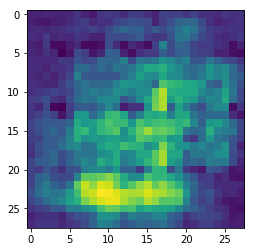

Example image from dataset...


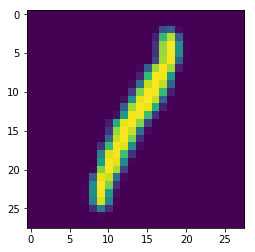

Epoch 6/20... Discriminator Loss: 0.6532... Generator Loss: 1.9701
Network generated image...


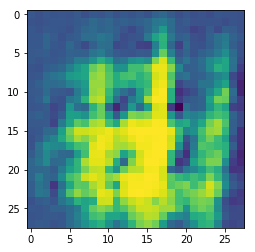

Example image from dataset...


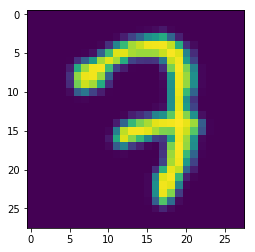

Epoch 6/20... Discriminator Loss: 0.6518... Generator Loss: 1.9921
Network generated image...


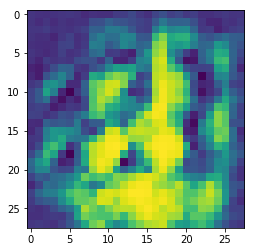

Example image from dataset...


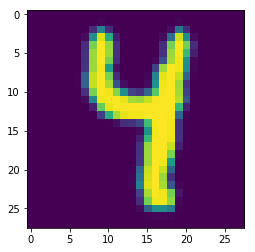

Epoch 6/20... Discriminator Loss: 0.6622... Generator Loss: 2.0089
Network generated image...


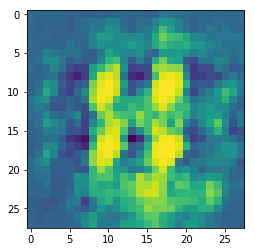

Example image from dataset...


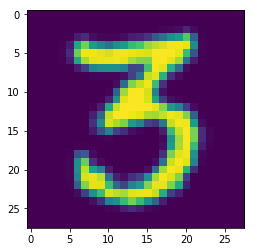

Epoch 6/20... Discriminator Loss: 0.6562... Generator Loss: 1.9204
Network generated image...


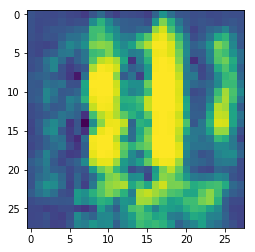

Example image from dataset...


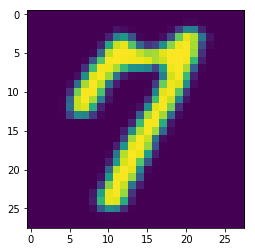

Epoch 7/20... Discriminator Loss: 0.6534... Generator Loss: 2.0571
Network generated image...


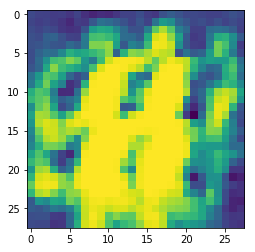

Example image from dataset...


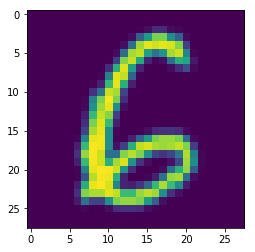

Epoch 7/20... Discriminator Loss: 0.6525... Generator Loss: 2.0011
Network generated image...


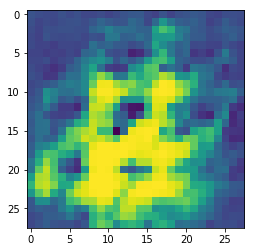

Example image from dataset...


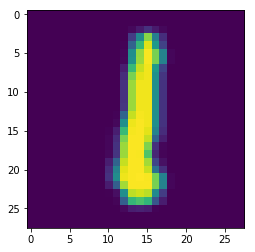

Epoch 7/20... Discriminator Loss: 0.6514... Generator Loss: 2.0253
Network generated image...


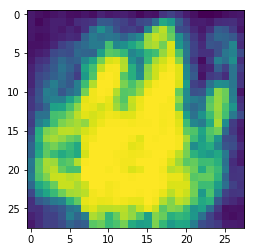

Example image from dataset...


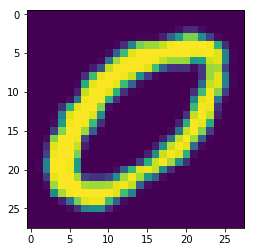

Epoch 7/20... Discriminator Loss: 0.6511... Generator Loss: 2.0186
Network generated image...


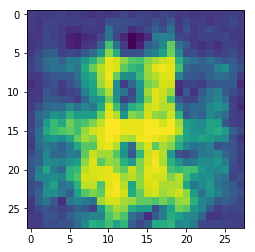

Example image from dataset...


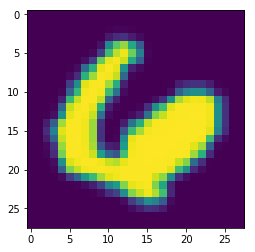

Epoch 8/20... Discriminator Loss: 0.6516... Generator Loss: 1.9839
Network generated image...


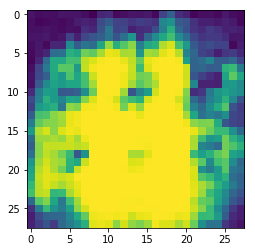

Example image from dataset...


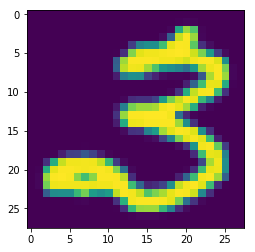

Epoch 8/20... Discriminator Loss: 0.6521... Generator Loss: 2.0019
Network generated image...


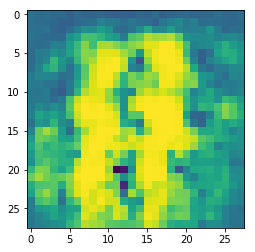

Example image from dataset...


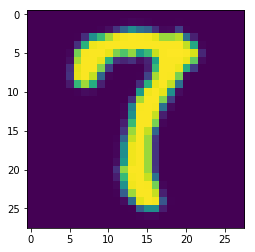

Epoch 8/20... Discriminator Loss: 0.6510... Generator Loss: 2.0409
Network generated image...


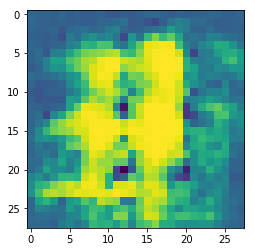

Example image from dataset...


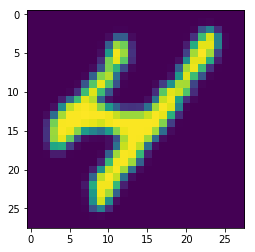

Epoch 8/20... Discriminator Loss: 0.6526... Generator Loss: 2.0495
Network generated image...


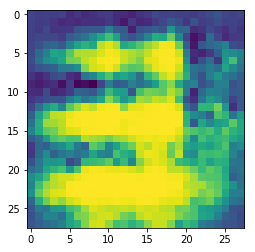

Example image from dataset...


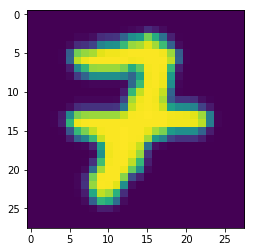

Epoch 9/20... Discriminator Loss: 0.6559... Generator Loss: 2.0314
Network generated image...


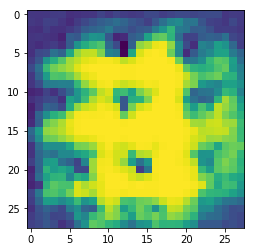

Example image from dataset...


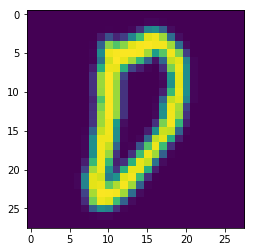

Epoch 9/20... Discriminator Loss: 0.6509... Generator Loss: 2.0707
Network generated image...


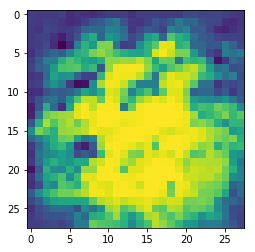

Example image from dataset...


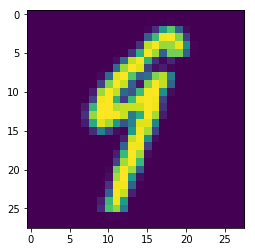

Epoch 9/20... Discriminator Loss: 0.6552... Generator Loss: 2.1765
Network generated image...


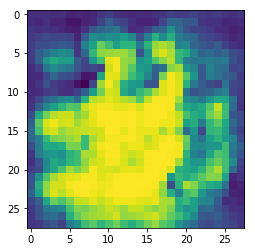

Example image from dataset...


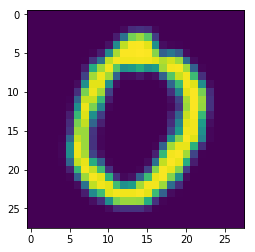

KeyboardInterrupt: 

In [11]:

# Run all those functions
input_real, input_z, _ = model_inputs(shape[1], shape[2], shape[3], z_dim)
d_loss, g_loss = net_loss(input_real, input_z, shape[3])
d_opt, g_opt = net_opt(d_loss, g_loss, learning_rate, beta1)

# Get the session and do the required initialization operations 
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

# Do the actual training of the network
# Takes a batch, turns it into NP arrays and feeds it through. 
# It will also output an example of its current learning every so often so I can see
# how much I've failed to teach this damn network to do anything other than generate noise
num_steps = int(num_examples/batch_size)
for epoch_i in range(epochs):
    for step in range(1, num_steps):
        
        #Get a batch
        labels, images = sess.run([labels_batch, images_batch])
        batch_z = np.random.normal(-1, 1, size=(batch_size, z_dim))

        _ = sess.run(d_opt, feed_dict={input_real: images, input_z: batch_z})
        if(step%5 == 0): #I believe InfoGAN found you should train D more than G
            _ = sess.run(g_opt, feed_dict={input_real: images, input_z: batch_z})

        if step % (int(num_steps/5)) == 0:            
            #Get a batch
            labels, images = sess.run([labels_batch, images_batch])
            # At the end of every 10 epochs, get the losses and print them out
            train_loss_d = d_loss.eval({input_z: batch_z, input_real: images}, session=sess)
            train_loss_g = g_loss.eval({input_z: batch_z}, session=sess)
            
            #clear_output()
            print("Epoch {}/{}...".format(epoch_i+1, epochs),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))

            _ = show_generator_output(sess, 1, input_z, shape[3], images[0])
